In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import random
import time
import h5py
from pathlib import Path

from tomobar.methodsDIR import RecToolsDIR
from tomobar.supp.suppTools import normaliser

In [2]:
#Data shape: [n_sample, c, h, w]

In [46]:
#12923:  
n_darks = 20  
n_flats = 40  
n_projections = 1840  
n_post_flats = 0  
vert_tuple = [i for i in range(500,800)]
horiz_tuple = [i for i in range(300,900)]
# Angles = (1841)

In [47]:
PATH = "/dls/science/users/lqg38422/data/12923/12923.nxs"

h5py_list = h5py.File(PATH, "r")

darks = h5py_list['/entry1/instrument/flyScanDetector/data'][:n_darks,vert_tuple,:][:,:,horiz_tuple]
darks = darks.transpose((1,0,2))
flats = h5py_list['/entry1/instrument/flyScanDetector/data'][n_darks:n_flats,vert_tuple,:][:,:,horiz_tuple]
flats = flats.transpose((1,0,2))
data_raw = h5py_list['/entry1/instrument/flyScanDetector/data'][n_flats:n_projections,vert_tuple,:][:,:,horiz_tuple]
data_raw = data_raw.transpose((1,0,2))
projData3D_norm = normaliser(data_raw, flats=flats, darks=darks, log='true', method='mean')
angles = h5py_list['/entry1/tomo_entry/data/rotation_angle'][:] # extract angles
angles_rad = angles[40:1840]*np.pi/180.0

h5py_list.close()
del darks, flats, data_raw

In [48]:
projData3D_norm.shape

(300, 1800, 600)

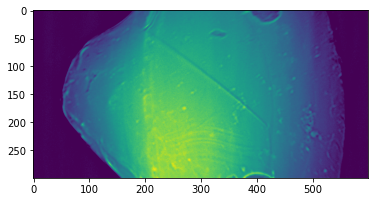

In [49]:
plt.imshow(projData3D_norm[:,150,:])

In [50]:
def split_rec(projData3D_norm, P, N_size, angles_rad, num_splits = 4):
        # Reconstruct
        print("FUNCTION")
        RectoolsDIR = RecToolsDIR(DetectorsDimH = P,  # DetectorsDimH # detector dimension (horizontal)
                        DetectorsDimV = N_size,  # DetectorsDimV # detector dimension (vertical) for 3D case only
                        CenterRotOffset = None, # Center of Rotation (CoR) scalar (for 3D case only)
                        AnglesVec = angles_rad, # array of angles in radians
                        ObjSize = N_size, # a scalar to define reconstructed object dimensions
                        device_projector = 'gpu')

        print("FBP - Noisy projection")
        tmp = RectoolsDIR.FBP(projData3D_norm) # FBP reconstruction
    
        # Reconstruct noisy splits
        print("FBP - Split projection")
        noisy_splits_rec_tmp = [] #/0, /1, /2, ...
        for j in range(num_splits):
            RectoolsDIR = RecToolsDIR(DetectorsDimH = P,  # DetectorsDimH # detector dimension (horizontal)
                            DetectorsDimV = N_size,  # DetectorsDimV # detector dimension (vertical) for 3D case only
                            CenterRotOffset = None, # Center of Rotation (CoR) scalar (for 3D case only)
                            AnglesVec = angles_rad[j::num_splits], # array of angles in radians
                            ObjSize = N_size, # a scalar to define reconstructed object dimensions
                            device_projector = 'gpu')
            sino_split = projData3D_norm[:, j::num_splits, :]
            rec = RectoolsDIR.FBP(sino_split)
            rec = torch.tensor(rec)
            noisy_splits_rec_tmp.append(rec)
        
        return torch.tensor(tmp), torch.stack(noisy_splits_rec_tmp)

In [51]:
#(1800, 1199) != ... len(angles_rad) should be equal to sino_shape (projData3D_norm.shape[1])

In [62]:
N_size = projData3D_norm.shape[0]
P = projData3D_norm[2]

In [63]:
noisy_rec, noisy_splits_rec = split_rec(projData3D_norm, P, N_size, angles_rad, num_splits = 4)

FUNCTION
FBP - Noisy projection


Exception: Unable to initialize Projector2D.

slice_num: 44


(<AxesSubplot:title={'center':'SPLIT DATA'}>,
 Text(0.5, 1.0, 'SPLIT DATA'),
 <matplotlib.image.AxesImage at 0x2b27aa2739e8>)

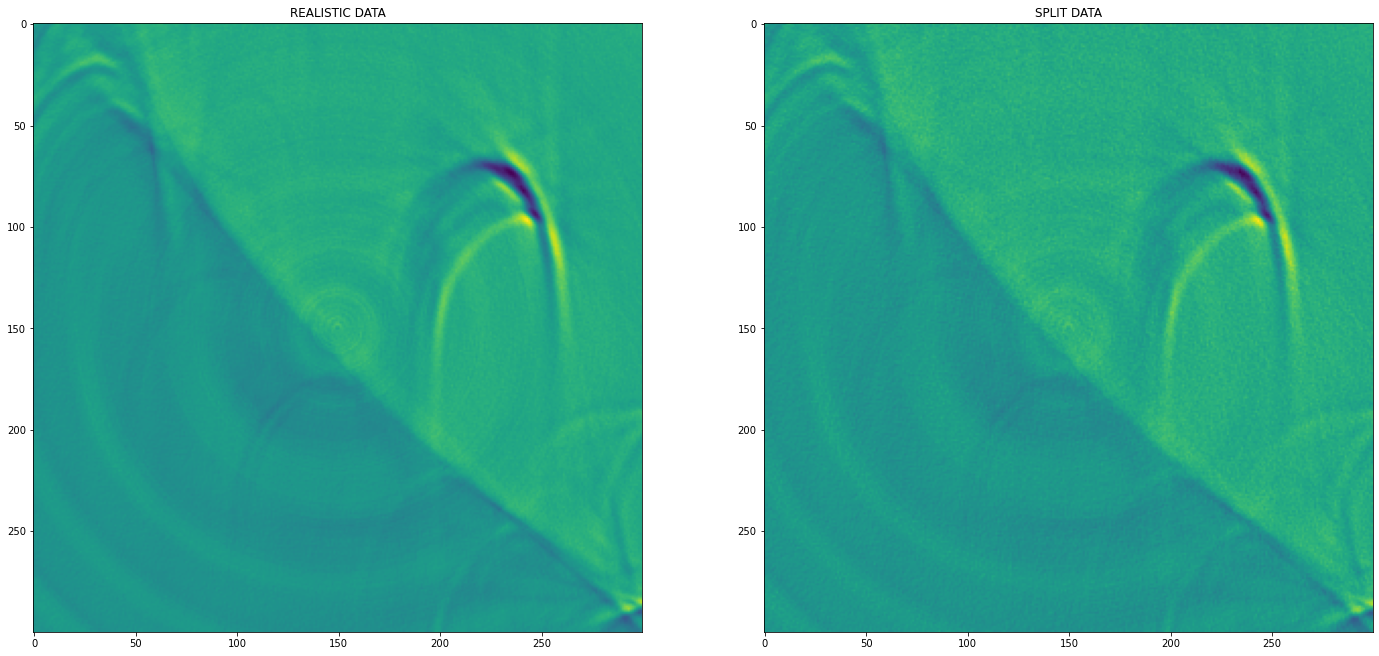

In [21]:
slice_num = np.random.randint(0, noisy_rec.shape[2])
print("slice_num:", slice_num)
plt.figure(figsize=(24,24))
plt.subplot(1,2,1), plt.title("REALISTIC DATA"), plt.imshow(noisy_rec[slice_num,:,:])
plt.subplot(1,2,2), plt.title("SPLIT DATA"), plt.imshow(noisy_splits_rec[0][slice_num,:,:])